In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'RecYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [4]:
sql_path = '../../sql/RecYards/recyards_wr_backtest_training.sql'.format(variable, variable.lower())
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

10682


# Load Receptions model and use it as a features

In [5]:
def read_model(model_dir, model_name):
    """
    """
    model_path = model_dir + model_name + '.pkl'
    features_path = model_dir + 'features/' + model_name + '.features'

    # Open the pickle file in binary read mode
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    # Open the .txt file in read mode and read the lines
    features = []
    with open(features_path, 'r') as file:
        for line in file:
            # Remove leading and trailing whitespace and append the line to the features list
            features.append(line.strip())

    return model, features

In [6]:
wr_model_dir = '../../models/Receptions/'
wr_model_name = 'xgb_xreceptions_wr_backtest'
wr_model_file_path = wr_model_dir + wr_model_name

rb_model_dir = '../../models/Receptions/'
rb_model_name = 'xgb_xreceptions_rb_backtest'
rb_model_file_path = rb_model_dir + rb_model_name

te_model_dir = '../../models/Receptions/'
te_model_name = 'xgb_xreceptions_te_backtest'
te_model_file_path = te_model_dir + te_model_name

wr_receptions_model, wr_receptions_features = read_model(wr_model_dir, wr_model_name)
rb_receptions_model, rb_receptions_features = read_model(rb_model_dir, rb_model_name)
te_receptions_model, te_receptions_features = read_model(te_model_dir, te_model_name)

### Split data into train/test/validation

In [7]:
# Remove inf values (there aren't many)
raw_data = raw_data.loc[~raw_data.isin([np.inf, -np.inf]).any(axis=1)]
print(len(raw_data))

10682


In [8]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [9]:
# Prepare features
lag_features = [i for i in raw_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
raw_data['Moneyline'] = raw_data['Moneyline'].apply(lambda x: convert_odds(x)) 

#features = [i.replace('Lag','') for i in lag_features] + ['PointSpread','PointTotal','Moneyline','HomeFlag','xReceptions','PositionId']
features = [i.replace('Lag','') for i in lag_features] + ['PointSpread','PointTotal','Moneyline','HomeFlag']

all_features = features + [target_variable]

In [12]:
train_test_data = raw_data.copy()

## Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]
#
#wr_train_test_data = train_test_data[train_test_data['Position'] == 'WR'].copy()
#rb_train_test_data = train_test_data[train_test_data['Position'] == 'RB'].copy()
#te_train_test_data = train_test_data[train_test_data['Position'] == 'TE'].copy()
#
#wr_train_test_data['xReceptions'] = wr_receptions_model.predict(wr_train_test_data[wr_receptions_features])
#rb_train_test_data['xReceptions'] = rb_receptions_model.predict(rb_train_test_data[rb_receptions_features])
#te_train_test_data['xReceptions'] = te_receptions_model.predict(te_train_test_data[te_receptions_features])
#
#train_test_data = pd.concat([wr_train_test_data, rb_train_test_data, te_train_test_data])

In [13]:
# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

### Use random search to narrow down hyperparameter grid

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\Sean\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.5339707235718726, 'gamma': 0.38545610187291096, 'learning_rate': 0.05263930125350873, 'max_depth': 2, 'min_child_weight': 8, 'n_estimators': 66, 'reg_alpha': 0.41279355060675227, 'reg_lambda': 7.050255496889531, 'subsample': 0.5188002407877083}
Best Score (R-squared): 0.25860135695910935
Test R-squared: 0.23542745295374334
Test RMSE: 32.5141
Test MAE: 25.0582


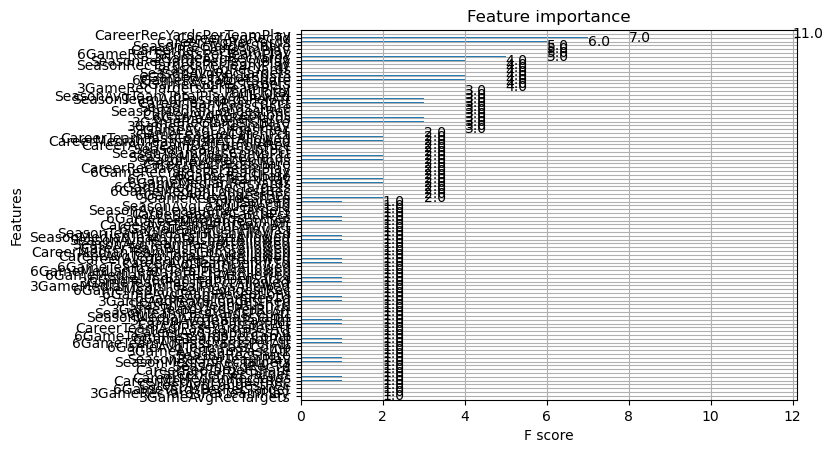

,TargetRecYards,pred_TargetRecYards,residuals
6075,19.0,32.380611,-13.380611
3544,19.0,32.277737,-13.277737
9290,3.0,23.659357,-20.659357
5032,10.0,24.280155,-14.280155
2483,42.0,47.933762,-5.933762


In [14]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Define parameter grid for RandomizedSearchCV with improved distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.4),  
    'max_depth': randint(2, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.1, 0.7),
    'colsample_bytree': uniform(0.3, 0.7),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.001, 10)
}

# Create XGBoost regressor with GPU support (if available)
xgb = XGBRegressor(random_state=42, use_label_encoder=False)

# Set up cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV with efficient parameter settings
xgb_random = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=300, 
    cv=kfolds, 
    verbose=3, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model on the training data
xgb_random.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Display best parameters and scores
print("Best Parameters:", xgb_random.best_params_)
print("Best Score (R-squared):", xgb_random.best_score_)

# Evaluate on the test set
best_xgb = xgb_random.best_estimator_

y_pred_test = best_xgb.predict(X_test)
test_r2_score = best_xgb.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Test R-squared:", test_r2_score)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot feature importance
plot_importance(best_xgb)
plt.show()

# Create and display output DataFrame
output_df = pd.DataFrame({target_variable: y_test, 'pred_' + target_variable: y_pred_test})
output_df['residuals'] = output_df[target_variable] - output_df['pred_' + target_variable]
output_df.head()

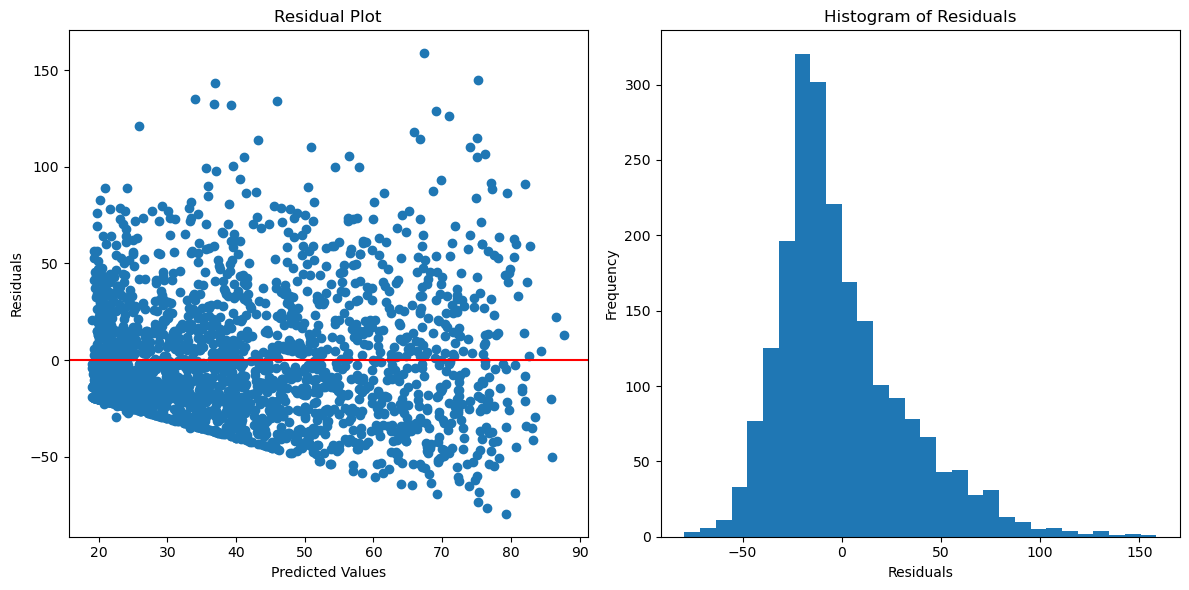

In [15]:
# Calculate residuals
residuals = y_test - y_pred_test

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

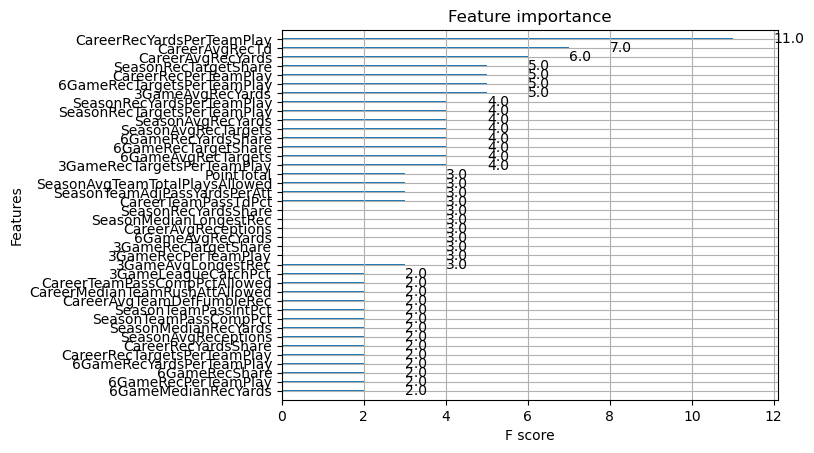

<Figure size 1800x1200 with 0 Axes>

In [16]:
# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=40)
plt.figure(figsize=(18, 12))
plt.show()

### Persist the best model in the models dir

In [17]:
model_dir = '../../models/{}/'.format(variable)

model_file_path = model_dir + 'xgb_x{}_wr_backtest.pkl'.format(variable.lower())
joblib.dump(best_xgb, model_file_path)

['../../models/RecYards/xgb_xrecyards_wr_backtest.pkl']

In [18]:
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + 'features/xgb_x{}_wr_backtest.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")

In [19]:
test = pd.DataFrame(X_test.loc[170]).T

test

,3GameAvgLongestRec,3GameAvgRecTargets,3GameAvgRecTd,3GameAvgRecYards,3GameAvgReceptions,3GameCatchPct,3GameMedianLongestRec,3GameMedianRecTargets,3GameMedianRecTd,3GameMedianRecYards,3GameMedianReceptions,3GameRecPerTeamPlay,3GameRecShare,3GameRecTargetShare,3GameRecTargetsPerTeamPlay,3GameRecYardsPerTeamPlay,3GameRecYardsShare,3GameYardsPerRecTarget,3GameYardsPerRush,6GameAvgLongestRec,6GameAvgRecTargets,6GameAvgRecTd,6GameAvgRecYards,6GameAvgReceptions,6GameCatchPct,6GameMedianLongestRec,6GameMedianRecTargets,6GameMedianRecTd,6GameMedianRecYards,6GameMedianReceptions,6GameRecPerTeamPlay,6GameRecShare,6GameRecTargetShare,6GameRecTargetsPerTeamPlay,6GameRecYardsPerTeamPlay,6GameRecYardsShare,6GameYardsPerRecTarget,6GameYardsPerRush,CareerAvgLongestRec,CareerAvgRecTargets,CareerAvgRecTd,CareerAvgRecYards,CareerAvgReceptions,CareerCatchPct,CareerMedianLongestRec,CareerMedianRecTargets,CareerMedianRecTd,CareerMedianRecYards,CareerMedianReceptions,CareerPerRecTarget,CareerRecPerTeamPlay,CareerRecShare,CareerRecTargetShare,CareerRecTargetsPerTeamPlay,CareerRecYardsPerTeamPlay,CareerRecYardsShare,CareerYardsPerRec,SeasonAvgLongestRec,SeasonAvgRecTargets,SeasonAvgRecTd,SeasonAvgRecYards,SeasonAvgReceptions,SeasonCatchPct,SeasonMedianLongestRec,SeasonMedianRecTargets,SeasonMedianRecTd,SeasonMedianRecYards,SeasonMedianReceptions,SeasonPerRecTarget,SeasonRecPerTeamPlay,SeasonRecShare,SeasonRecTargetShare,SeasonRecTargetsPerTeamPlay,SeasonRecYardsPerTeamPlay,SeasonRecYardsShare,SeasonYardsPerRec,3GameAvgTeamNetPassYards,3GameAvgTeamPassAtt,3GameAvgTeamPassComp,3GameAvgTeamPassInt,3GameAvgTeamPassTd,3GameAvgTeamPassYards,3GameAvgTeamSackYardsLost,3GameAvgTeamTimesSacked,3GameMedianTeamNetPassYards,3GameMedianTeamPassAtt,3GameMedianTeamPassComp,3GameMedianTeamPassInt,3GameMedianTeamPassTd,3GameMedianTeamPassYards,3GameMedianTeamSackYardsLost,3GameMedianTeamTimesSacked,3GameTeamAdjPassYardsPerAtt,3GameTeamPassCompPct,3GameTeamPassIntPct,3GameTeamPassTdPct,3GameTeamPassYardsPerAtt,3GameTeamPassYardsPerComp,6GameAvgTeamNetPassYards,6GameAvgTeamPassAtt,6GameAvgTeamPassComp,6GameAvgTeamPassInt,6GameAvgTeamPassTd,6GameAvgTeamPassYards,6GameAvgTeamSackYardsLost,6GameAvgTeamTimesSacked,6GameMedianTeamNetPassYards,6GameMedianTeamPassAtt,6GameMedianTeamPassComp,6GameMedianTeamPassInt,6GameMedianTeamPassTd,6GameMedianTeamPassYards,6GameMedianTeamSackYardsLost,6GameMedianTeamTimesSacked,6GameTeamAdjPassYardsPerAtt,6GameTeamPassCompPct,6GameTeamPassIntPct,6GameTeamPassTdPct,6GameTeamPassYardsPerAtt,6GameTeamPassYardsPerComp,CareerAvgTeamNetPassYards,CareerAvgTeamPassAtt,CareerAvgTeamPassComp,CareerAvgTeamPassInt,CareerAvgTeamPassTd,CareerAvgTeamPassYards,CareerAvgTeamSackYardsLost,CareerAvgTeamTimesSacked,CareerMedianTeamNetPassYards,CareerMedianTeamPassAtt,CareerMedianTeamPassComp,CareerMedianTeamPassInt,CareerMedianTeamPassTd,CareerMedianTeamPassYards,CareerMedianTeamSackYardsLost,CareerMedianTeamTimesSacked,CareerTeamAdjPassYardsPerAtt,CareerTeamPassCompPct,CareerTeamPassIntPct,CareerTeamPassTdPct,CareerTeamPassYardsPerAtt,CareerTeamPassYardsPerComp,SeasonAvgTeamNetPassYards,SeasonAvgTeamPassAtt,SeasonAvgTeamPassComp,SeasonAvgTeamPassInt,SeasonAvgTeamPassTd,SeasonAvgTeamPassYards,SeasonAvgTeamSackYardsLost,SeasonAvgTeamTimesSacked,SeasonMedianTeamNetPassYards,SeasonMedianTeamPassAtt,SeasonMedianTeamPassComp,SeasonMedianTeamPassInt,SeasonMedianTeamPassTd,SeasonMedianTeamPassYards,SeasonMedianTeamSackYardsLost,SeasonMedianTeamTimesSacked,SeasonTeamAdjPassYardsPerAtt,SeasonTeamPassCompPct,SeasonTeamPassIntPct,SeasonTeamPassTdPct,SeasonTeamPassYardsPerAtt,SeasonTeamPassYardsPerComp,3GameAvgTeamRushAtt,3GameAvgTeamRushTd,3GameAvgTeamRushYards,3GameMedianTeamRushAtt,3GameMedianTeamRushTd,3GameMedianTeamRushYards,3GameTeamRushTdPct,3GameTeamYardsPerRush,6GameAvgTeamRushAtt,6GameAvgTeamRushTd,6GameAvgTeamRushYards,6GameMedianTeamRushAtt,6GameMedianTeamRushTd,6GameMedianTeamRushYards,6GameTeamRushTdPct,6GameTeamYardsPerRush,CareerAvgTeamRushAtt,CareerAvgTea